# Health Claims

In this notebook we will show a workflow to obtain a report analyzing collection of biomedicine claims stated in different type of texts using a single instance of a large language model (LLM).

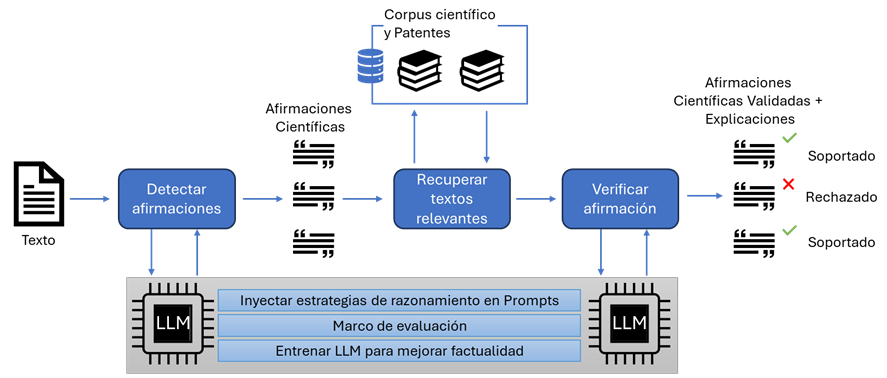

First we will use the LLM to extract the claims from the objetive text. After that, we will find related abstracts from a dataset of trustworthy sources, such as Pubmed. Finally, we will ask again the LLM for a report for each pair of claim-abstract, giving a label (SUPPORT, CONTRADICT or NOT ENOUGH INFORMATION - NEI), the rationale for that decision and the most related sentence from the verified abstract.

# 1. Prerequisites

**IMPORTANT**: This notebook uses a large language model which needs extensive computation power. Please use a runtime with GPU to run it. Google Collab provides with a T4 which can allocate the model Llama-3.2-3B-Instruct which we plan to use in inference.

## Load libraries

In [ ]:
!pip install vllm
!pip install triton
!pip install json_repair
!pip install rank_bm25

In [ ]:
from vllm import LLM, SamplingParams
import huggingface_hub
from transformers import AutoTokenizer
import srsly
import json_repair
import json
import math
import re
from collections import Counter
import numpy as np
from rank_bm25 import BM25Okapi

## Aux functions

In [ ]:
def find_sub_list(sublist, full_list):
    sub_list_length = len(sublist)
    for ind in (i for i, e in enumerate(full_list) if e == sublist[0]):
        if full_list[ind : ind + sub_list_length] == sublist:
            return ind, ind + sub_list_length

def get_confidence(log_probs, output_tokens, label_tokens):
    label_span = find_sub_list(sublist=label_tokens, full_list=output_tokens)
    linear_probs = []
    for label_token_index, log_prob_index in enumerate(
        range(label_span[0], label_span[1])
    ):
        label_token_id = label_tokens[label_token_index]
        log_prob = log_probs[log_prob_index][label_token_id].logprob
        linear_prob = np.round(np.exp(log_prob) * 100, 2)
        linear_probs.append(linear_prob)
    confidence = np.round(np.mean(linear_probs), decimals=2)
    return confidence

## Login in huggingface

In order to run the models from this notebook, it is necessary have access to them. Please login with your Huggingface account and accept the terms and conditions of Llama3.2:
https://huggingface.co/meta-llama/Llama-3.2-3B-Instruct

After that, you need to introduce your Huggingface Access Token in the following cell. If you don't know how to obtain it, please read the next article: https://huggingface.co/docs/hub/security-tokens

In [ ]:
huggingface_hub.login()

# 2. Initialize model, tokenizer and verification data

First, we instantiate the model, the tokenizer and the sampling parameters we will use in execution time to obtain the claim analysis report. You can tune the top_p and temperature values as you please.

In [ ]:
seed = 42

model = LLM(model="meta-llama/Llama-3.2-3B-Instruct", dtype="half", max_model_len=16384)
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-3B-Instruct")
sampling_params = SamplingParams(
    temperature=0.7,
    top_p=1.0,
    max_tokens=1024,
    logprobs=0,
)

Second, we will load the verification dataset. It must be a corpus with trustworthy documents which can be used as the database to factcheck the health claims against. In this case, we will use a delimited collection of abstracts from Pubmed, along with their DOIs and titles.

In [ ]:
verified_corpus = [x for x in srsly.read_jsonl("verified_corpus.jsonl")]
tokenized_corpus = [doc["abstract"].split(" ") for doc in verified_corpus]
bm25 = BM25Okapi(tokenized_corpus)

# 3. Input text

In the following cell you can select the text to analyze:

In [ ]:
text = """Do Genes Have a Role in Obesity?

In recent decades, obesity has reached epidemic proportions in populations whose environments promote physical inactivity and increased consumption of high-calorie foods. However, not all people living in such environments will become obese, nor will all obese people have the same body fat distribution or suffer the same health problems. These differences can be seen in groups of people with the same racial or ethnic background and even within families. Genetic changes in human populations occur too slowly to be responsible for the obesity epidemic. Nevertheless, the variation in how people respond to the same environment suggests that genes do play a role in the development of obesity.
"""

# 4. Claim Analysis

## Claim generation

The claims generation have two phases: first, we will ask for a list of claims stated on the text; second, we  will try to reformulate those claims to solve coreferences.

In [ ]:
claim_extraction_prompt = """Your task is to generate a list with the main factual claims stated in a text. A factual claim makes an assertion about something regarding the subject matter that can be proved or contradicted with factual evidence. Factual claims must be expressed as meaningful, self-contained sentences. Do not include narrative context and disregard absolutely ALL self-referential parts.

Arrange your output using the format "-- claim\\n-- claim\\n-- claim"."""

user_prompt = f"""

    TEXT: {text}

    OUTPUT:

    """
messages = [
    {"role": "system", "content": claim_extraction_prompt},
    {"role": "user", "content": user_prompt},
]
prompt = tokenizer.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
outputs = model.generate([prompt], sampling_params)
generated_text = outputs[0].outputs[0].text

In [ ]:
claim_clean_prompt = "Now use the context to rewrite the nouns and pronouns in each individual claim to solve coreferences, replacing them with the most specific and technical form seen in the text."

messages.append({"role": "assistant", "content": generated_text})
messages.append({"role": "user", "content": claim_clean_prompt})
prompt = tokenizer.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
outputs = model.generate([prompt], sampling_params)
clean_generation = outputs[0].outputs[0].text

claim_candidates = []
lines = clean_generation.split("\n")
for line in lines:
    if line.startswith("--"):
        claim = line.split("--")[1].strip()
        claim_candidates.append({"claim": claim})

In [ ]:
for claim_candidate in claim_candidates:
  print(claim_candidate)

## Abstract retrieval

Here we will use the bm25 ranking function to obtain the most related abstract from the verified dataset to each claim from the list.

In [ ]:
for i, claim_dict in enumerate(claim_candidates):
    query = claim_dict["claim"]
    tokenized_query = query.split(" ")
    search_results = bm25.get_top_n(tokenized_query, verified_corpus, n=3)
    claim_dict["search_results"] = search_results

In [ ]:
for claim_candidate in claim_candidates:
  print(claim_candidate)

## Claim Fact-checking

Finally, we will obtain the report with the label, the rationale and the evidence for each claim-abstract pair as a json document.

In [ ]:
claim_analyst_prompt = """You are a claim analyst. Upon receiving a claim and an evidence, your task is to figure out if the claim is either supported, refuted or unrelated based exclusively on the evidence.

- If you are confident that the claim is supported by the evidence your answer will be "SUPPORT".
- If you are certain that the evidence directly contradicts the claim, your answer will be "REFUTE". Please note that if the claim is just not mentioned in the evidence, or if it is unrelated to the evidence, it does not mean it is refuted. For that cases, the answer will be "NEI".
- If the evidence does not contain enough information or if it is not related to the claim, your answer will be "NEI", which stands for Not Enough Information.

Arrange the output as a JSON dictionary with the keys "response", "rationale" and "evidence" and ensure your output is JSON-valid.
- The "response" values can only be "SUPPORT", "REFUTE" or "NEI".
- The "rationale" value must be an explanation for your answer.
- The "evidence" value must be a list of sentences from the evidence which are more related to your decision. If the decision is "NEI", this field will be empty."""

prompts = []
for claim_dict in claim_candidates:
    claim = claim_dict["claim"]
    search_results = claim_dict["search_results"]
    for search_result in search_results:
        user_prompt = f"""

                    CLAIM: {claim}

                    """
        user_prompt += "EVIDENCE: \nTitle: {}\nText: {}\n\n".format(
            search_result["title"], search_result["abstract"]
        )
        user_prompt += 'OUTPUT: {{"output": "<INSERT OUTPUT HERE>"}}'
        messages = [
            {"role": "system", "content": claim_analyst_prompt},
            {"role": "user", "content": user_prompt},
        ]
        prompt = tokenizer.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
        prompts.append(prompt)

In [ ]:
outputs = model.generate(prompts, sampling_params)
label_tokens_dict = {
    label: tokenizer.encode(label, add_special_tokens=False)
    for label in ["SUPPORT", "REFUTE"]
}
for claim_candidate, output in zip(claim_candidates, outputs):
    report = json_repair.loads(output.outputs[0].text)
    if "response" in report and report["response"] != "NEI":
        log_probs=output.outputs[0].logprobs
        output_tokens=list(output.outputs[0].token_ids)
        label_tokens=label_tokens_dict[report["response"]]
        label_span = find_sub_list(sublist=label_tokens, full_list=output_tokens)
        linear_probs = []
        for label_token_index, log_prob_index in enumerate(
            range(label_span[0], label_span[1])
        ):
            label_token_id = label_tokens[label_token_index]
            log_prob = log_probs[log_prob_index][label_token_id].logprob
            linear_prob = np.round(np.exp(log_prob) * 100, 2)
            linear_probs.append(linear_prob)
        confidence = np.round(np.mean(linear_probs), decimals=2)
        report["confidence"] = confidence
    for search_result in claim_candidate["search_results"]:
      search_result["report"] = report


In [ ]:
final_claims = []
for claim_dict in claim_candidates:
    out_claim_dict = {}
    for k, v in claim_dict.items():
        if k == "search_results":
            out_claim_dict["claim_analysis"] = [x for x in v if "report" in x]
        else:
            out_claim_dict[k] = v
    if len(out_claim_dict["claim_analysis"]) > 0:
        final_claims.append(out_claim_dict)

In [ ]:
report = json.dumps({"input_text": text, "claims": final_claims}, indent=4)
print(report)